# Data imbalance analysis
## Comparing the impact of dataset imbalance on classification performance metrics
In this notebook, we are going to explore how data imbalance affect classification scores on four different tasks, which have been chosen to exemplify typical use cases of ML analysis in neuroscience. To keep it simple, we will focus on binary classification problems (0 vs 1).

The four tasks are :
1. Synthetic data
2. EEG alpha oscillations (resting-state Eyes-Closed vs Eyes-Open)
3. MEG alpha oscillations (auditory vs visual stimulation)
4. MEG alpha oscillations (faces vs scrambled) 

In these tasks, we will observe the effect of data imbalance on 4 different performance metrics :   
1. Decoding Accuracy (Acc)  
2. Area Under the Curve (AUC)
3. F1
4. Balanced Accuracy (BAcc)

Finally, a few parameters of the classification pipeline must be kept in mind as they can also differentially impact performance on imbalanced data. Namely :
- Dataset size
- Classifier type
    - Support Vector Machine (SVM)
    - Linear Discriminant Analysis (LDA)
    - Logistic Regression (LR)
    - Random Forest (RF)
- Cross-validation scheme
    - K-Fold, k=5
    - Stratified K-Fold
    - Group K-Fold

## Imports
First, we start by importing functions from the provided toolbox as well as some useful plotting functions.

In [32]:

from imbalance.pipeline import Pipeline
from imbalance.viz import metric_balance, data_distribution, plot_different_cvs, plot_different_n
from imbalance.data import eegbci, gaussian_binary
from joblib import Parallel, delayed
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    StratifiedGroupKFold,
)
import os
import numpy as np
import matplotlib.pyplot as plt
import string
from copy import deepcopy
import pickle
import warnings
warnings.simplefilter("ignore", RuntimeWarning)
plt.style.use('seaborn')

## Task 1 : Synthetic data
For that first classification task, we will generate data from two gaussian distributions, with means of 0 and 2.

In [3]:
pls = []

def run(distance):
    # generate random data
    x, y, groups = gaussian_binary(n_samples_per_class=500, mean_distance=distance)
    # run the pipeline
    pl = Pipeline(
        x,
        y,
        groups,
        dataset_balance=np.linspace(0.1, 0.9, 25),
        classifiers=["lr", "lda", "svm", "rf"],
        n_permutations=100,
        n_init=10,
    )
    pl.evaluate()
    return deepcopy(pl)



pls = Parallel(n_jobs=3)(delayed(run)(dist) for dist in [0, 1, 3])

fitting classifiers: 100%|██████████| 1000/1000 [27:14<00:00,  1.63s/it, size=1, balance=0.9, classifier=RandomForestClassifier]       

In [33]:
pls_path = "../imbalance/data/synthetic_pipelines.pickle"

with open(pls_path, "wb") as f:
    pickle.dump(pls, f)

In [4]:
# generate random data
x, y, groups = gaussian_binary(n_samples_per_class=1500, mean_distance=1)
# run the pipeline
pl_nsamples = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],# "rf"]
    n_permutations=0,
    n_init=10,
    dataset_size=(0.1, 0.33, 1),
)
pl_nsamples.evaluate()

fitting classifiers:   0%|                             | 0/750 [00:00<?, ?it/s, size=0.1, balance=0.1, classifier=SVC]


fitting classifiers: 100%|█████████████████████| 750/750 [03:41<00:00,  3.39it/s, size=1, balance=0.9, classifier=SVC]


In [5]:

pls_crossvals = {}
cv_names = ["KFold", "Stratified"]#, "Stratified Group"]
cvs = [KFold(n_splits=5), StratifiedKFold(n_splits=5)]#, StratifiedGroupKFold(n_splits=5)]
# generate random data
x, y, groups = gaussian_binary(n_samples_per_class=50, n_groups=5, mean_distance=1)
# run the pipeline
for idx_cv, cross_val in enumerate(cvs):
    pl = Pipeline(
        x,
        y,
        groups,
        dataset_balance=np.linspace(0.1, 0.9, 25),
        classifiers=["lr", "lda", "svm", "rf"],
        n_permutations=1,
        n_init=40,
        cross_validation=cross_val,
    )
    pl.evaluate()
    pls_crossvals[cv_names[idx_cv]] = deepcopy(pl)
    




fitting classifiers:   0%|               | 0/4000 [00:00<?, ?it/s, size=1, balance=0.1, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predic

/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:   0%| | 7/4000 [00:00<04:50, 13.75it/s, size=1, balance=0.133, classifier=RandomForestClassifier]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes n

fitting classifiers:   2%| | 91/4000 [00:06<04:02, 16.11it/s, size=1, balance=0.833, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:   2%| | 95/4000 [00:06<04:45, 13.66it/s, size=1, balance=0.867, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning:

fitting classifiers:   5%|▏  | 192/4000 [00:10<02:03, 30.81it/s, size=1, balance=0.867, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:   5%| | 193/4000 [00:10<02:03, 30.81it/s, size=1, balance=0.867, classifier=LinearDiscriminantAna/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:   5%|▊                 | 194/4000 [00:10<02:03, 30.81it/s, size=1, balance=0.867, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
f

fitting classifiers:   7%|█▍                  | 286/4000 [00:12<01:50, 33.71it/s, size=1, balance=0.8, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:   7%| | 287/4000 [00:12<01:50, 33.71it/s, size=1, balance=0.8, classifier=RandomForestClassifier]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:   7%| | 291/4000 [00:13<01:49, 33.92it/s, size=1, balance=0.833, classifier=RandomForestClassifie/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
f

fitting classifiers:   8%| | 309/4000 [00:13<01:46, 34.60it/s, size=1, balance=0.167, classifier=LinearDiscriminantAna/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:   8%|█▍                | 310/4000 [00:13<01:46, 34.60it/s, size=1, balance=0.167, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:   8%| | 311/4000 [00:13<01:46, 34.60it/s, size=1, balance=0.167, classifier=RandomForestClassifie/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classif

fitting classifiers:  10%|▌    | 412/4000 [00:16<02:10, 27.47it/s, size=1, balance=0.2, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  10%| | 413/4000 [00:17<02:10, 27.47it/s, size=1, balance=0.2, classifier=LinearDiscriminantAnaly/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  10%|██                  | 414/4000 [00:17<02:10, 27.47it/s, 

fitting classifiers:  15%|▍  | 588/4000 [00:22<01:52, 30.44it/s, size=1, balance=0.833, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  15%|▏| 589/4000 [00:22<01:52, 30.44it/s, size=1, balance=0.833, classifier=LinearDiscriminantAna/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  15%|██▋               | 590/4000 [00:22<01:52, 30.44it/s, size=1, balance=0.833, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
f

fitting classifiers:  15%|▍  | 616/4000 [00:23<01:43, 32.67it/s, size=1, balance=0.233, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  15%|▏| 617/4000 [00:23<01:43, 32.67it/s, size=1, balance=0.233, classifier=LinearDiscriminantAna/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  15%|██▊               | 618/4000 [00:23<01:43, 32.67it/s, si

fitting classifiers:  20%|▏| 793/4000 [00:28<01:33, 34.38it/s, size=1, balance=0.867, classifier=LinearDiscriminantAna/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  20%|███▌              | 794/4000 [00:28<01:33, 34.38it/s, size=1, balance=0.867, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  20%|▏| 795/4000 [00:28<01:33, 34.38it/s, size=1, balance=0.867, classifier=RandomForestClassifie/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/

fitting classifiers:  22%|█▏   | 900/4000 [00:31<01:30, 34.35it/s, size=1, balance=0.1, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  23%|▏| 901/4000 [00:31<01:30, 34.35it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnaly/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  23%|▏| 915/4000 [00:32<01:27, 35.12it/s, size=1, balance=0.2, classifier=RandomForestClassifier]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  25%|████▍             | 990/4000 [00:34<01:32, 32.70it/s, size=1, balance=0.833, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  25%|▏| 991/4000 [00:34<01:32, 32.70it/s, size=1, balance=0.833, classifier=RandomForestClassifie/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
f

fitting classifiers:  28%|▎| 1101/4000 [00:37<01:21, 35.47it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  28%|█████▏             | 1102/4000 [00:37<01:21, 35.47it/s, size=1, balance=0.1, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  30%|▎| 1199/4000 [00:41<01:39, 28.27it/s, size=1, balance=0.9, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  30%|█▏  | 1200/4000 [00:41<01:41, 27.58it/s, size=1, balance=0.1, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true

fitting classifiers:  32%|▎| 1287/4000 [00:44<01:40, 26.90it/s, size=1, balance=0.8, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  32%|▎| 1291/4000 [00:44<01:39, 27.28it/s, size=1, balance=0.833, classifier=RandomForestClassifi/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  32%|▋ | 1292/4000 [00:44<01:41, 26.56it/s, size=1, balance=0.867, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
f

fitting classifiers:  35%|▎| 1399/4000 [00:48<01:38, 26.43it/s, size=1, balance=0.9, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  35%|█▍  | 1400/4000 [00:48<01:36, 26.99it/s, size=1, balance=0.1, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  35%|▎| 1401/4000 [00:48<01:36, 26.99it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classif

/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  38%|▊ | 1504/4000 [00:52<01:27, 28.40it/s, size=1, balance=0.133, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predic

fitting classifiers:  40%|▍| 1605/4000 [00:55<01:23, 28.70it/s, size=1, balance=0.133, classifier=LinearDiscriminantAn/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  40%|██████▊          | 1606/4000 [00:55<01:23, 28.70it/s, size=1, balance=0.133, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  40%|▍| 1607/4000 [00:55<01:23, 28.70it/s, size=1, balance=0.

fitting classifiers:  43%|▍| 1701/4000 [00:59<01:25, 26.98it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  43%|████████           | 1702/4000 [00:59<01:25, 26.98it/s, size=1, balance=0.1, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  43%|███████▎         | 1710/4000 [00:59<01:22, 27.61it/s, size=1, balance=0.167, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  43%|▍| 1711/4000 [00:59<01:22, 27.61it/s, size=1, balance=0.167, classifier=RandomForestClassifi/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  45%|▍| 1801/4000 [01:02<01:15, 29.22it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  45%|████████▌          | 1802/4000 [01:02<01:15, 29.22it/s, size=1, balance=0.1, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  45%|▍| 1803/4000 [01:02<01:15, 29.22it/s, size=1, balance=0.

fitting classifiers:  48%|▍| 1907/4000 [01:06<01:12, 29.02it/s, size=1, balance=0.133, classifier=RandomForestClassifi/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  48%|▉ | 1908/4000 [01:06<01:11, 29.39it/s, size=1, balance=0.167, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  48%|▍| 1909/4000 [01:06<01:11, 29.39it/s, size=1, balance=0.

fitting classifiers:  50%|█████████▌         | 2014/4000 [01:09<01:06, 30.00it/s, size=1, balance=0.2, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  50%|▌| 2015/4000 [01:09<01:06, 30.00it/s, size=1, balance=0.2, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  50%|█ | 2016/4000 [01:09<01:08, 28.91it/s, size=1, balance=0.233, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classif

fitting classifiers:  55%|▌| 2201/4000 [01:16<01:01, 29.10it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predic

fitting classifiers:  57%|▌| 2299/4000 [01:19<00:57, 29.79it/s, size=1, balance=0.9, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  57%|██▎ | 2300/4000 [01:19<00:56, 29.93it/s, size=1, balance=0.1, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true

fitting classifiers:  60%|▌| 2399/4000 [01:22<00:56, 28.21it/s, size=1, balance=0.9, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  60%|██▍ | 2400/4000 [01:23<00:56, 28.35it/s, size=1, balance=0.1, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  60%|▌| 2401/4000 [01:23<00:56, 28.35it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classif

fitting classifiers:  63%|███████████▉       | 2502/4000 [01:26<00:52, 28.49it/s, size=1, balance=0.1, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  63%|▋| 2503/4000 [01:26<00:52, 28.49it/s, size=1, balance=0.1, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  65%|██▌ | 2600/4000 [01:30<00:46, 30.13it/s, size=1, balance=0.1, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  65%|▋| 2601/4000 [01:30<00:46, 30.13it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  65%|████████████▎      | 2602/4000 [01:30<00:46, 30.13it/s, 

fitting classifiers:  68%|████████████▊      | 2702/4000 [01:33<00:42, 30.31it/s, size=1, balance=0.1, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  68%|▋| 2703/4000 [01:33<00:42, 30.31it/s, size=1, balance=0.1, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  68%|█▎| 2704/4000 [01:33<00:42, 30.64it/s, size=1, balance=0.133, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classif

fitting classifiers:  70%|▋| 2801/4000 [01:36<00:39, 30.47it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  70%|█████████████▎     | 2802/4000 [01:36<00:39, 30.47it/s, size=1, balance=0.1, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  73%|▋| 2901/4000 [01:40<00:35, 30.55it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  73%|█████████████▊     | 2902/4000 [01:40<00:35, 30.55it/s, size=1, balance=0.1, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  73%|▋| 2903/4000 [01:40<00:35, 30.55it/s, size=1, balance=0.

fitting classifiers:  75%|████████████▊    | 3006/4000 [01:43<00:32, 30.78it/s, size=1, balance=0.133, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  75%|▊| 3007/4000 [01:43<00:32, 30.78it/s, size=1, balance=0.133, classifier=RandomForestClassifi/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  75%|█▌| 3008/4000 [01:43<00:33, 29.37it/s, size=1, balance=0.167, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classif

fitting classifiers:  78%|██████████████▋    | 3102/4000 [01:46<00:28, 31.06it/s, size=1, balance=0.1, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  78%|▊| 3103/4000 [01:46<00:28, 31.06it/s, size=1, balance=0.1, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  80%|▊| 3205/4000 [01:50<00:26, 30.16it/s, size=1, balance=0.133, classifier=LinearDiscriminantAn/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  80%|█████████████▋   | 3206/4000 [01:50<00:26, 30.16it/s, size=1, balance=0.133, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  83%|█▋| 3304/4000 [01:53<00:25, 26.97it/s, size=1, balance=0.133, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  83%|▊| 3305/4000 [01:53<00:25, 26.97it/s, size=1, balance=0.133, classifier=LinearDiscriminantAn/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  83%|██████████████   | 3306/4000 [01:53<00:25, 26.97it/s, si

fitting classifiers:  85%|█▋| 3404/4000 [01:57<00:21, 27.66it/s, size=1, balance=0.133, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  85%|▊| 3405/4000 [01:57<00:21, 27.66it/s, size=1, balance=0.133, classifier=LinearDiscriminantAn/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

fitting classifiers:  88%|▉| 3503/4000 [02:00<00:16, 30.71it/s, size=1, balance=0.1, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  88%|█▊| 3504/4000 [02:00<00:16, 30.70it/s, size=1, balance=0.133, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samp

fitting classifiers:  90%|▉| 3595/4000 [02:03<00:13, 30.38it/s, size=1, balance=0.867, classifier=RandomForestClassifi/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  90%|███▌| 3596/4000 [02:03<00:13, 30.45it/s, size=1, balance=0.9, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  90%|▉| 3597/4000 [02:03<00:13, 30.45it/s, size=1, balance=0.9, classifier=LinearDiscriminantAnal/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
f

fitting classifiers:  92%|▉| 3677/4000 [02:06<00:10, 30.50it/s, size=1, balance=0.733, classifier=LinearDiscriminantAn/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  92%|▉| 3679/4000 [02:06<00:10, 30.50it/s, size=1, balance=0.733, classifier=RandomForestClassifi/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  92%|▉| 3687/4000 [02:06<00:10, 30.00it/s, size=1, balance=0.8, classifier=RandomForestClassifier/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
f

fitting classifiers:  93%|▉| 3711/4000 [02:07<00:09, 30.32it/s, size=1, balance=0.167, classifier=RandomForestClassifi/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  95%|█▉| 3792/4000 [02:10<00:06, 30.97it/s, size=1, balance=0.867, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
fitting classifiers:  95%|▉| 3793/4000 [02:10<00:06, 30.97it/s, size=1, balance=0.867, classifier=LinearDiscriminantAn/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classif

fitting classifiers:  95%|▉| 3809/4000 [02:10<00:06, 28.95it/s, size=1, balance=0.167, classifier=LinearDiscriminantAn/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  95%|████████████████▏| 3810/4000 [02:10<00:06, 28.95it/s, size=1, balance=0.167, classifier=SVC]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  95%|▉| 3811/4000 [02:10<00:06, 28.95it/s, size=1, balance=0.

fitting classifiers:  98%|█▉| 3904/4000 [02:13<00:03, 30.68it/s, size=1, balance=0.133, classifier=LogisticRegression]/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
fitting classifiers:  98%|▉| 3905/4000 [02:13<00:03, 30.68it/s, size=1, balance=0.133, classifier=LinearDiscriminantAn/home/hyruuk/anaconda3/envs/imbalance/lib/python3.8/site-packages/sklearn/metrics/

In [6]:
# generate random data
x, y, groups = gaussian_binary(n_samples_per_class=500, mean_distance=1)
# run the pipeline
pl_balance = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],# "rf"]
    n_permutations=0,
    n_init=10,
    single_balanced_split=True,
)
pl_balance.evaluate()

fitting classifiers: 100%|█████████████████████| 250/250 [00:13<00:00, 18.55it/s, size=1, balance=0.9, classifier=SVC]


In [31]:
# load data
with open(pls_path, "rb") as f:
    pls = pickle.load(f)


# visualize the result
fig, axes = plt.subplots(7, 3, figsize=(20, 30), dpi=300, 
                         gridspec_kw=dict(height_ratios=[1, 1, 1, 1, 1, 0.1, 1]))
figtitle = "Synthetic data"
#fig.suptitle(figtitle, fontsize=25)
classifiers=["lr", "lda", "svm", "rf"]
spot_names = string.ascii_uppercase[:18]

show_leg_distrib=True
show_leg_metric=True
spot_idx = 0
for dist_idx, dist in enumerate([0,1,3]):
    for ax_idx, ax in enumerate(axes[:,dist_idx]):
        if ax_idx == 0:
            data_distribution(pls[dist_idx], ax=ax, show=False, show_leg=show_leg_distrib)
            show_leg_distrib=False
        elif ax_idx < 5:
            metric_balance(pls[dist_idx], ax=ax, show=False, classifier=classifiers[ax_idx-1], show_leg=show_leg_metric)
            show_leg_metric = False
        elif ax_idx == 6:
            if dist_idx == 0:
                plot_different_n(pl_nsamples, ax=ax, show=False, classifier="svm", show_leg=True, metric="accuracy")
            if dist_idx == 1:
                plot_different_cvs(pls_crossvals, ax=ax, show=False, classifier="svm", show_leg=True, metric="accuracy")
            if dist_idx == 2:
                metric_balance(pl_balance, ax=ax, show=False, classifier="svm", show_leg=True)
        if ax_idx != 5:
            ax.text(-0.1, 1.05, spot_names[spot_idx], transform=ax.transAxes, 
                size=20, weight='bold')
            spot_idx += 1
        if ax_idx == 5:
            ax.axis('off')
            
        
cols = ['Distance = 0', 'Distance = 1', 'Distance = 3']
rows = ["LDA", "LR", "SVM", "RF", "Secondary parameters"]

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

fig.tight_layout()
plt.show()

NameError: name 'imbalance' is not defined

In [ ]:
metrics=[ "roc_auc","accuracy", "f1", "balanced_accuracy"]
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

#pls_crossvals_light = pls_crossvals[:2]
for ax_idx,ax in enumerate(axes.flat):
    plot_different_cvs(pls_crossvals, ax=ax, show=False, classifier="svm", show_leg=True, metric=metrics[ax_idx])

In [ ]:
plot_different_n(pl_nsamples, show=False, classifier="svm", show_leg=True, metric="accuracy")

## Task 2 : EEG analysis

In [10]:
#pipeline_path="../imbalance/data/eeg.pickle"
features_path ="../imbalance/data/eeg_features.npy"

# load or generate dataset
if not os.path.isfile(features_path):
    x, y, groups = eegbci('../imbalance/data',roi=lambda x: x[0] in ['P','O'])
    np.save(features_path,dict(x=x, y=y, groups=groups))
else:
    features = np.load(features_path,allow_pickle=True).item()
    x, y, groups = features["x"] , features["y"] , features["groups"]

In [13]:
pl = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["lda","svm","lr", "rf"]
)
# fit and evaluate classifiers on dataset configurations
pl.evaluate()

pl_nsamples = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],# "rf"]
    n_permutations=0,
    n_init=10,
    dataset_size=(0.1, 0.33, 1),
)
pl_nsamples.evaluate()


fitting classifiers:   0%|       | 0/1000 [00:00<?, ?it/s, size=1, balance=0.1, classifier=LinearDiscriminantAnalysis]
fitting classifiers:   0%| | 1/1000 [00:06<1:52:47,  6.77s/it, size=1, balance=0.1, classifier=LinearDiscriminantAnaly
fitting classifiers:   0%| | 4/1000 [00:39<2:57:45, 10.71s/it, size=1, balance=0.1, classifier=RandomForestClassifier]
fitting classifiers:   0%| | 4/1000 [00:39<2:57:45, 10.71s/it, size=1, balance=0.133, classifier=LinearDiscriminantAna
fitting classifiers:   0%| | 5/1000 [00:44<2:26:55,  8.86s/it, size=1, balance=0.133, classifier=LinearDiscriminantAna
fitting classifiers:   1%|   | 7/1000 [01:03<2:26:03,  8.83s/it, size=1, balance=0.133, classifier=LogisticRegression]
fitting classifiers:   1%| | 7/1000 [01:03<2:26:03,  8.83s/it, size=1, balance=0.133, classifier=RandomForestClassifie
fitting classifiers:   1%| | 8/1000 [01:19<3:01:31, 10.98s/it, size=1, balance=0.133, classifier=RandomForestClassifie
fitting classifiers:   1%| | 8/1000 [01:19<3:01

fitting classifiers:   4%|  | 35/1000 [09:11<5:56:03, 22.14s/it, size=1, balance=0.367, classifier=LogisticRegression]
fitting classifiers:   4%| | 35/1000 [09:11<5:56:03, 22.14s/it, size=1, balance=0.367, classifier=RandomForestClassifi
fitting classifiers:   4%| | 36/1000 [09:30<5:41:24, 21.25s/it, size=1, balance=0.367, classifier=RandomForestClassifi
fitting classifiers:   4%| | 36/1000 [09:30<5:41:24, 21.25s/it, size=1, balance=0.4, classifier=LinearDiscriminantAnal
fitting classifiers:   4%| | 37/1000 [09:36<4:26:29, 16.60s/it, size=1, balance=0.4, classifier=LinearDiscriminantAnal
fitting classifiers:   4%|▏   | 39/1000 [11:08<7:30:03, 28.10s/it, size=1, balance=0.4, classifier=LogisticRegression]
fitting classifiers:   4%| | 39/1000 [11:08<7:30:03, 28.10s/it, size=1, balance=0.4, classifier=RandomForestClassifier
fitting classifiers:   4%| | 40/1000 [11:30<6:57:49, 26.11s/it, size=1, balance=0.4, classifier=RandomForestClassifier
fitting classifiers:   4%| | 40/1000 [11:30<6:57

KeyboardInterrupt: 

IndexError: list index out of range

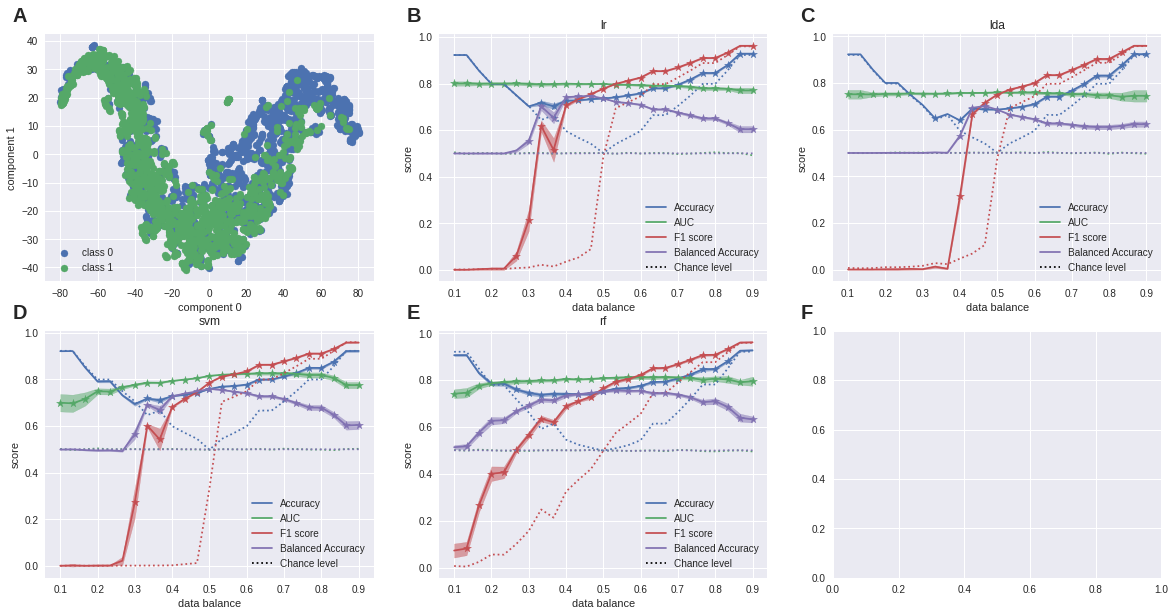

In [24]:
fpath = "../imbalance/data/eeg_roi_multi_Stratified-Group.pickle"
with open(fpath, "rb") as f:
    pl = pickle.load(f)

# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
figtitle = "EEG data"
#fig.suptitle(figtitle, fontsize=25)
classifiers=["lr", "lda", "svm", "rf"]

for ax_idx,ax in enumerate(axes.flat):
    ax.text(-0.1, 1.05, string.ascii_uppercase[ax_idx], transform=ax.transAxes, 
            size=20, weight='bold')
    if ax_idx == 0:
        data_distribution(pl, ax=ax, show=False)
    elif ax_idx < 5:
        metric_balance(pl, ax=ax, show=False, classifier=classifiers[ax_idx-1])
    #elif ax_idx == 6:
        #plot_different_n(pl_nsamples, ax=ax, show=False, classifier="svm", show_leg=True, metric="accuracy")

## Task 3 : MEG 1

In [ ]:
# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
figtitle = "MEG CAMCAN data"
#fig.suptitle(figtitle, fontsize=25)
classifiers=["lr", "lda", "svm", "rf"]

for ax_idx,ax in enumerate(axes.flat):
    ax.text(-0.1, 1.05, string.ascii_uppercase[ax_idx], transform=ax.transAxes, 
            size=20, weight='bold')
    if ax_idx == 0:
        data_distribution(pl, ax=ax, show=False)
    elif ax_idx < 5:
        metric_balance(pl, ax=ax, show=False, classifier="svm")

## Task 4 : MEG 2

In [ ]:
import pickle
fpath = "../imbalance/data/eeg_roi_multi_Stratified-Group.pickle"

with open(fpath, "rb") as f:
    pl = pickle.load(f)

# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
figtitle = "EEG data"
#fig.suptitle(figtitle, fontsize=25)
classifiers=["lr", "lda", "svm", "rf"]

for ax_idx,ax in enumerate(axes.flat):
    ax.text(-0.1, 1.05, string.ascii_uppercase[ax_idx], transform=ax.transAxes, 
            size=20, weight='bold')
    if ax_idx == 0:
        data_distribution(pl, ax=ax, show=False)
    elif ax_idx < 6:
        metric_balance(pl, ax=ax, show=False, classifier=classifiers[ax_idx-1])
    #elif ax_idx == 6:
        #plot_different_n(pl_nsamples, ax=ax, show=False, classifier="svm", show_leg=True, metric="accuracy")